# Import Libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pdb

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.externals.six import StringIO
from sklearn.externals import joblib
from IPython.core.display import Image, display
import seaborn as sns
sns.set(style="ticks")

# EDA

In [2]:
# load data
train_df = pd.read_csv('train.csv')

# check for missing values in frame. 
print("Is any null value in this data:", train_df.isnull().values.any())
print("Raw training set shape:", train_df.shape)

predictors = list(train_df) # includes ID and target/class columns
train_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)

### We intend to verify that the binary features are mutually exclusive (wilderness and soils features). 
soils_only_df = train_df[train_df.columns[15:-1]] # extract columns of soil types. leave out the class column.
sums = soils_only_df.sum(axis=1) # total each row. 
for i in range(sums.shape[0]):
    if sums.iloc[i] != 1:
        print("Not mutually exclusive or no soil type in this sample:", i)
wilderness_only_df = train_df[train_df.columns[11:15]] # extract columns of wilderness types
sums = wilderness_only_df.sum(axis=1) # total each row. 
for i in range(sums.shape[0]):
    if sums.iloc[i] != 1:
        print("Not mutually exclusive or no wilderness type in this sample:", i)

# Now, combine all soil columns into a single soil multifactor column. Ditto for Wilderness_Area* 
# Caveat: The train data's ID starts from 1, while panda's index starts from 0. 
# Don't forget to tag on the class column. 

### make a function out of this as well. will need it to transform actual test data. 
train_mod_df = train_df.iloc[:,:11].copy() # grab all rows from 0 thru 10. 
train_mod_df['WILDERNESS']=0 # Replaces Wilderness_Area* features. 
train_mod_df['SOILS']=0 # Replaces Soil_Type* features. 

for index, row in train_df.iterrows():
    for j in range(15,row.shape[0]-1): # make sure you don't grab the class column
        if row.iloc[j] == 1.0:
            train_mod_df.loc[index,'SOILS'] = j-14 # values start from 1

for index, row in train_df.iterrows():
    for j in range(11,15): # make sure you don't grab the class column
        if row.iloc[j] == 1.0:
            train_mod_df.loc[index,'WILDERNESS'] = j-10 # values start from 1

train_mod_df[target] = train_df[target] # Add back the Class column

('Is any null value in this data:', False)
('Raw training set shape:', (15120, 56))
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


In [3]:
# Rename dataframe for consistency
train_df = train_mod_df
train_df.shape

(15120, 14)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WILDERNESS', 'SOILS']


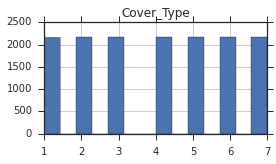

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


('After split, Train and Dev dataset shapes are:', (12096, 14), (3024, 14))


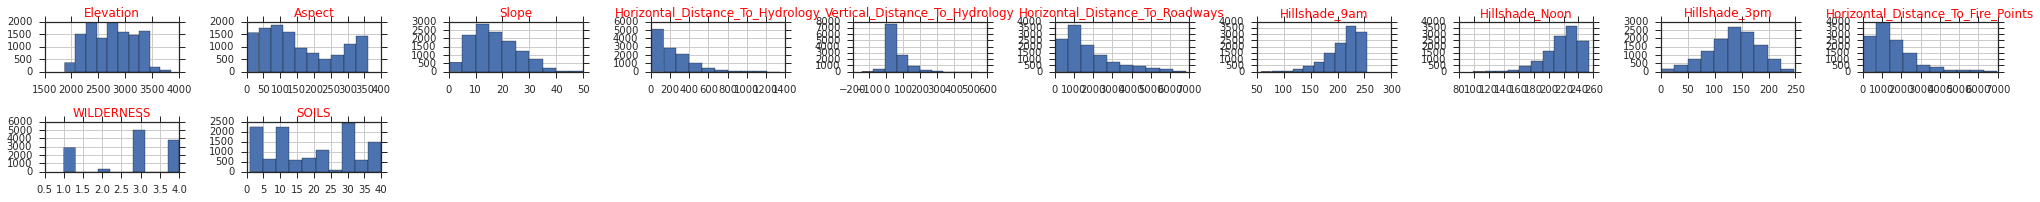

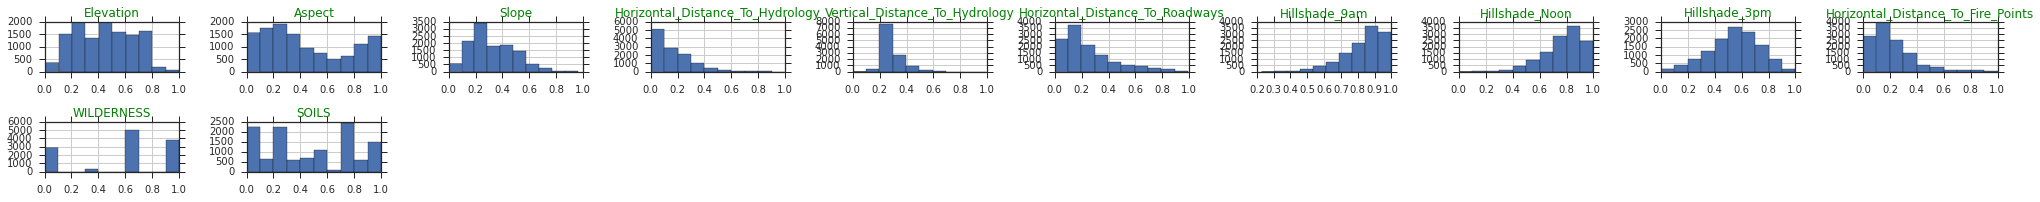

In [4]:
# Get predictors out again
predictors = list(train_df) # includes ID and target/class columns
train_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)

# two kinds of normalization - min-max or z-score. z-score may lead to negative values for otherwise non-negative quantities 
# (such as altitude) - which may be ok from a prediction standpoint 

# Need to store these values for normalizing new data presented to the eventual model for prediction. 
train_df_mean =  train_df.mean().astype(float)
train_df_sd = train_df.std().astype(float)
train_df_min = train_df.min().astype(float)
train_df_max = train_df.max().astype(float)

# plot cover type histogram, check to see if any stratification is required for train,dev split. 
plt.figure(figsize=(4, 2))
ax = train_df['Cover_Type'].hist(bins=14)
ax.set_title('Cover_Type')
plt.show()
train_df, dev_df = train_test_split(train_df,test_size=0.2)

### plot histograms before and after min-max normalization
# display histograms for basic EDA. titles in Red. 
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    ax = data.hist()
    #ax.axis([train_df_min[predictors][i], train_df_max[predictors][i], 0, 4000])
    ax.set_title(predictors[i],color='Red')

# going with min-max. tries z-scores before, but now doubt it will work well for SOIL and WILDERNESS
train_df[predictors] = (train_df[predictors]-train_df_min[predictors])/(train_df_max[predictors]-train_df_min[predictors])
dev_df[predictors] = (dev_df[predictors]-train_df_min[predictors])/(train_df_max[predictors]-train_df_min[predictors])

print("After split, Train and Dev dataset shapes are:",train_df.shape, dev_df.shape)

# display histograms post normalization. Titles in Green.
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    aax = data.hist()
    aax.set_title(predictors[i],color='Green') 
    
#spm = pd.plotting.scatter_matrix(train_df[predictors[0:10]], alpha=0.5, figsize=(15,15), diagonal='hist')
#sns.pairplot(train_df[predictors[10:]])

# Base Model

In [58]:
# our base model is knn we will attempt to improve our accuracy score from here

knn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', leaf_size=30)
knn.fit(train_df[predictors], train_df[target])
dev_pred = knn.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.78      0.68      0.73       436
          2       0.70      0.68      0.69       416
          3       0.76      0.73      0.74       410
          4       0.89      0.90      0.89       481
          5       0.85      0.93      0.89       446
          6       0.75      0.79      0.77       410
          7       0.93      0.97      0.95       425

avg / total       0.81      0.81      0.81      3024



# Weak Models

In [59]:
# Attempt linear support vector classifier, weak results

lsvc = LinearSVC(C=1)
lsvc.fit(train_df[predictors],train_df[target])
dev_pred = lsvc.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.61      0.47      0.53       436
          2       0.51      0.45      0.48       416
          3       0.48      0.49      0.48       410
          4       0.77      0.90      0.83       481
          5       0.64      0.50      0.57       446
          6       0.48      0.56      0.52       410
          7       0.77      0.93      0.84       425

avg / total       0.61      0.62      0.61      3024



In [60]:
# Attempt softmax regression, weak results

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",C=4)
softmax_reg.fit(train_df[predictors], train_df[target])
dev_pred = softmax_reg.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.66      0.60      0.63       436
          2       0.53      0.50      0.51       416
          3       0.55      0.48      0.52       410
          4       0.80      0.87      0.83       481
          5       0.67      0.69      0.68       446
          6       0.54      0.59      0.57       410
          7       0.83      0.89      0.86       425

avg / total       0.66      0.67      0.66      3024



# Random Forest

### Tree bagging method (simplified random forest): repeat random sampling in the data to run Decision Tree, then use the majority vote classification for all predictions to make a final prediction.
- The result of 10 bootstrap iterations shows an improved accuracy from ~0.75(single decision tree) to 0.83

In [19]:
np.random.seed(500)

def sample_index(n):
    bootstrap_sample_index = np.random.choice(range(n), size=n, replace=True)
    return bootstrap_sample_index

# Tree bagging with 10 bootstrap iterations
fc_tree_preds = np.empty((0,dev_df[target].shape[0]))
B = 10
for i in range(B):
    bootstrap_sample_index = sample_index(train_df[predictors].shape[0])
    fc_data = train_df[predictors].iloc[bootstrap_sample_index]
    fc_labels = train_df[target].iloc[bootstrap_sample_index]
    fc_tree = DecisionTreeClassifier(criterion="entropy", splitter="best")
    fc_tree.fit(fc_data, fc_labels)
    print(fc_tree.score(dev_df[predictors], dev_df[target]))
    fc_tree_preds = np.vstack((fc_tree_preds, fc_tree.predict(dev_df[predictors])))

# Use the majority vote classification for the predictions above
fc_tree_preds_transpose = fc_tree_preds.transpose().astype('int')
print(fc_tree_preds_transpose.shape)
# Find the label with the max count out of B times for each data
c = np.zeros(fc_tree_preds_transpose.shape[0])
for i in range(dev_df[target].shape[0]):
    c[i] = np.bincount(fc_tree_preds_transpose[i]).argmax()
# The accuracy of tree bagging method
print('accuracy of tree bagging with 10 bootstrap iterations', np.mean(c==dev_df[target]))

0.734126984127
0.756613756614
0.760912698413
0.74041005291
0.751984126984
0.761243386243
0.749338624339
0.74503968254
0.761574074074
0.760912698413
(3024, 10)
('accuracy of tree bagging with 10 bootstrap iterations', 0.82837301587301593)


### sklearn random forest

In [62]:
# Next, evaluate a Random Forest with 500 trees. This represents and improvement

rf = RandomForestClassifier(n_estimators=500, oob_score=True, criterion="entropy")
scores = cross_val_score(rf, train_df[predictors], train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))

Mean R^2 = 0.86


In [63]:
# Evaluate accuracy on dev data

rf.fit(train_df[predictors], train_df[target])
print(rf.score(dev_df[predictors], dev_df[target]))
dev_pred = rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

0.869047619048
             precision    recall  f1-score   support

          1       0.81      0.73      0.77       436
          2       0.76      0.72      0.74       416
          3       0.86      0.83      0.85       410
          4       0.95      0.97      0.96       481
          5       0.91      0.96      0.93       446
          6       0.83      0.88      0.85       410
          7       0.93      0.97      0.95       425

avg / total       0.87      0.87      0.87      3024



In [70]:
# Optimize parameters using GridSearch

param_grid = [
    {'n_estimators': [100, 250, 500, 750], 'max_features': [2, 4, 6, 8, 'auto'], 'oob_score':[True,False]},
    {'bootstrap': [False], 'n_estimators': [250, 500], 'max_features': [2, 4, 6, 8, 'auto'], 'min_samples_leaf': [1,5,10,50,100,200,500]},
  ]
rf = RandomForestClassifier()

start_time = time.time()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(train_df[predictors], train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Best params from grid search are:",grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
# Rerun random forest with best parameters obtained by Gridsearch

rf = RandomForestClassifier(bootstrap=False, max_features=4, n_estimators=250)
rf.fit(train_df[predictors],train_df[target])
print(rf.score(dev_df[predictors], dev_df[target]))
dev_pred = rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))
joblib.dump(rf, "rf.pkl")

In [ ]:
# Optimize random forest with random gridsearch

param_grid = {'n_estimators': [100,250,500,750],'max_features': [2, 4, 6, 8, 'log2'] }
rf = RandomForestClassifier(oob_score=True)

start_time = time.time()
random_search = RandomizedSearchCV(rf,param_distributions=param_grid, n_iter=20)
random_search.fit(train_df[predictors],train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Randomized grid search best params are:",random_search.best_params_)

In [ ]:
# Rerun random forest with best parameters obtained by random gridsearch

random_rf = RandomForestClassifier(n_estimators=250, max_features=4)
random_rf.fit(train_df[predictors],train_df[target])
print(random_rf.score(dev_df[predictors], dev_df[target]))
dev_pred = random_rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))
joblib.dump(random_rf, "random_rf.pkl")

# Voting Classifier

In [47]:
# Run Voting Classifier

voter = VotingClassifier(
    estimators=[('rf', rf),('lr', softmax_reg),('rrf', random_rf), ('knn', knn)],
    voting='hard')
voter.fit(train_df[predictors], train_df[target])
dev_pred = voter.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.75      0.75      0.75       434
          2       0.78      0.70      0.74       450
          3       0.86      0.85      0.86       438
          4       0.94      0.97      0.95       440
          5       0.92      0.95      0.93       442
          6       0.85      0.87      0.86       407
          7       0.94      0.95      0.95       413

avg / total       0.86      0.86      0.86      3024



In [ ]:
# Generalized voter

n_estimators_start = 100
n_estimators_end = 2501 # May take a while. 
n_estimators = [i for i in range(n_estimators_start,n_estimators_end)]
voter_models = [(str(k),RandomForestClassifier(n_estimators = k, max_features='auto', oob_score=True)) for k in n_estimators]
voter_models.append(('rrf', random_rf)) # append any tuples here. 
voter = VotingClassifier(
    estimators= voter_models,
    voting='soft')
start_time = time.time()
voter.fit(train_df[predictors], train_df[target])
dev_pred = voter.predict(dev_df[predictors])
end_time = time.time()
print(classification_report(dev_df[target],dev_pred))
print(voter.score(dev_df[predictors], dev_df[target]))
print("Wallclock time in secs for Voter:",end_time - start_time)
#print("Voter params: ", voter.get_params(deep=False)) # unfortunately, unable to extract winning candidate. 

# PCA

Variance explained by first 1 principal components: 0.437
Variance explained by first 2 principal components: 0.655
Variance explained by first 3 principal components: 0.751
Variance explained by first 4 principal components: 0.826
Variance explained by first 5 principal components: 0.874
Variance explained by first 6 principal components: 0.914
Variance explained by first 7 principal components: 0.945
Variance explained by first 8 principal components: 0.97
Variance explained by first 9 principal components: 0.984
Variance explained by first 10 principal components: 0.995
Variance explained by first 11 principal components: 1.0
Variance explained by first 12 principal components: 1.0


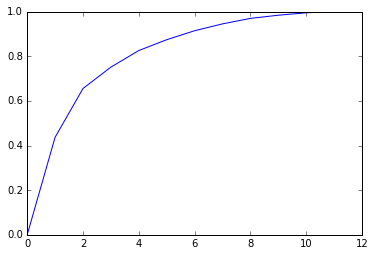

In [8]:
#PCA - find explained variance from each PC to determine an appropriate # of dimensions

from sklearn.decomposition import PCA

pca_mod = PCA(n_components=train_df.shape[1]-2)
pca_mod.fit(train_df[predictors])
explained_var = 0
exp_vars = [explained_var]

for k in range(0,train_df.shape[1]-2):
    explained_var += pca_mod.explained_variance_ratio_[k]
    exp_vars.append(explained_var)
    print("Variance explained by first", k+1, "principal components:", round(explained_var,3))
    
plt.plot(exp_vars)

In [ ]:
#Project data into n dimensions

n = 11
pca_mod = PCA(n_components = n)
projected_train = pca_mod.fit_transform(train_df[predictors])
projected_dev = pca_mod.transform(dev_df[predictors])

# Rerun Models with PCA

## KNN with PCA

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', leaf_size=30)
knn.fit(projected_train, train_df[target])
dev_pred = knn.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))

## Weaker Models with PCA - no meaningful improvement

In [82]:
# linear support vector classification w PCA

lsvc = LinearSVC(C=1)
lsvc.fit(projected_train,train_df[target])
dev_pred = lsvc.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.40      0.28      0.33       436
          2       0.41      0.29      0.34       416
          3       0.43      0.52      0.47       410
          4       0.73      0.91      0.81       481
          5       0.52      0.45      0.48       446
          6       0.47      0.42      0.44       410
          7       0.65      0.89      0.75       425

avg / total       0.52      0.54      0.52      3024



## Random Forest with PCA

In [83]:
# Optimize parameters for Random Forest with PCA with Gridsearch

param_grid = [
    {'n_estimators': [100, 250, 500, 750], 'max_features': [2, 4, 6, 8, 'auto'], 'oob_score':[True,False]},
    {'bootstrap': [False], 'n_estimators': [250, 500], 'max_features': [2, 4, 6, 8, 'auto']},
  ]
rf = RandomForestClassifier()

start_time = time.time()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(projected_train, train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Best params from grid search are:",grid_search.best_params_)


KeyboardInterrupt: 

In [29]:
# Run Random Forest with PCA with parameters obtained through gridsearch

rf = RandomForestClassifier(bootstrap=False, max_features='auto', n_estimators=500)
rf.fit(projected_train,train_df[target])
print(rf.score(projected_dev, dev_df[target]))
dev_pred = rf.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))


0.824404761905
             precision    recall  f1-score   support

          1       0.74      0.70      0.72       434
          2       0.73      0.66      0.69       450
          3       0.82      0.78      0.80       438
          4       0.90      0.95      0.92       440
          5       0.87      0.94      0.90       442
          6       0.78      0.82      0.80       407
          7       0.92      0.94      0.93       413

avg / total       0.82      0.82      0.82      3024



In [30]:
# Optimize Random Forest with PCA through random Grid Search

param_grid = {'n_estimators': [100,250,500,750],'max_features': [2, 4, 6, 8, 'log2'] }
rf = RandomForestClassifier(oob_score=True)

start_time = time.time()
random_search = RandomizedSearchCV(rf,param_distributions=param_grid, n_iter=20)
random_search.fit(projected_train,train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Randomized grid search best params are:",random_search.best_params_)

Wallclock time in secs for Random Forest Grid Search: 960.9144654273987
Randomized grid search best params are: {'max_features': 'log2', 'n_estimators': 750}


In [31]:
# Run random forest with PCA with parameters obtained through random gridsearch

random_rf = RandomForestClassifier(n_estimators=750, max_features='log2')
random_rf.fit(projected_train,train_df[target])
print(random_rf.score(projected_dev, dev_df[target]))
dev_pred = random_rf.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))

0.820767195767
             precision    recall  f1-score   support

          1       0.73      0.70      0.71       434
          2       0.72      0.64      0.68       450
          3       0.83      0.75      0.79       438
          4       0.88      0.96      0.92       440
          5       0.86      0.94      0.90       442
          6       0.78      0.82      0.80       407
          7       0.92      0.94      0.93       413

avg / total       0.82      0.82      0.82      3024



## Voting Classifier with PCA

In [37]:
# Run voting classifer with PCA

voter = VotingClassifier(
    estimators=[('rf', rf),('lr', softmax_reg),('rrf', random_rf), ('knn', knn)],
    voting='hard')
voter.fit(projected_train, train_df[target])
dev_pred = voter.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))

C:\Users\Jessica\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


             precision    recall  f1-score   support

          1       0.71      0.74      0.73       434
          2       0.71      0.62      0.66       450
          3       0.81      0.79      0.80       438
          4       0.89      0.95      0.92       440
          5       0.87      0.92      0.89       442
          6       0.80      0.79      0.80       407
          7       0.94      0.94      0.94       413

avg / total       0.82      0.82      0.82      3024



# Run Random Forest on real test data

In [ ]:
# load data
test_df = pd.read_csv('test.csv')

# check for missing values in frame. 
print("Is any null value in this data:", test_df.isnull().values.any())
print("Raw training set shape:", test_df.shape)

predictors = list(test_df) # includes ID and target/class columns
test_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)

### We intend to verify that the binary features are mutually exclusive (wilderness and soils features). 
soils_only_df = test_df[test_df.columns[15:-1]] # extract columns of soil types. leave out the class column.
sums = soils_only_df.sum(axis=1) # total each row. 
for i in range(sums.shape[0]):
    if sums.iloc[i] != 1:
        print("Not mutually exclusive or no soil type in this sample:", i)
wilderness_only_df = test_df[test_df.columns[11:15]] # extract columns of wilderness types
sums = wilderness_only_df.sum(axis=1) # total each row. 
for i in range(sums.shape[0]):
    if sums.iloc[i] != 1:
        print("Not mutually exclusive or no wilderness type in this sample:", i)

### transform actual test data. 
test_mod_df = test_df.iloc[:,:11].copy() # grab all rows from 0 thru 10. 
test_mod_df['WILDERNESS']=0 # Replaces Wilderness_Area* features. 
test_mod_df['SOILS']=0 # Replaces Soil_Type* features. 

for index, row in test_df.iterrows():
    for j in range(15,row.shape[0]-1): # make sure you don't grab the class column
        if row.iloc[j] == 1.0:
            test_mod_df.loc[index,'SOILS'] = j-14 # values start from 1

for index, row in test_df.iterrows():
    for j in range(11,15): # make sure you don't grab the class column
        if row.iloc[j] == 1.0:
            test_mod_df.loc[index,'WILDERNESS'] = j-10 # values start from 1

test_mod_df[target] = test_df[target] # Add back the Class column

# Rename dataframe for consistency
test_df = test_mod_df
test_df.shape

In [ ]:
# Get predictors out again
predictors = list(test_df) # includes ID and target/class columns
test_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)

# two kinds of normalization - min-max or z-score. z-score may lead to negative values for otherwise non-negative quantities 
# (such as altitude) - which may be ok from a prediction standpoint 

# Need to store these values for normalizing new data presented to the eventual model for prediction. 
train_df_mean =  train_df.mean().astype(float)
train_df_sd = train_df.std().astype(float)
train_df_min = train_df.min().astype(float)
train_df_max = train_df.max().astype(float)

# going with min-max. tries z-scores before, but now doubt it will work well for SOIL and WILDERNESS
test_df[predictors] = (test_df[predictors]-train_df_min[predictors])/(train_df_max[predictors]-train_df_min[predictors])

print("After split, Train and Dev dataset shapes are:",test_df.shape)

In [ ]:
# Next, evaluate a Random Forest with 500 trees. This represents and improvement

rf = RandomForestClassifier(n_estimators=500, oob_score=True, criterion="entropy")
scores = cross_val_score(rf, train_df[predictors], train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))

# Evaluate accuracy on dev data
rf.fit(train_df[predictors], train_df[target])
print(rf.score(test_df[predictors], test_df[target]))
dev_pred = rf.predict(test_df[predictors])
print(classification_report(test_df[target],test_pred))